# Aula 1 - Parte Prática - Agentes & Ambientes

## Introdução

Nesse primeiro notebook iremos aprender sobre a API do [OpenAI Gym](http://gym.openai.com/) e começaremos a implementar alguns componentes de um agente de RL.
Ao final dessa parte prática teremos implementado o **ciclo de interação Agente-Ambiente** que nos permitirá futuramente treinar o agente e avaliar sua performance.

<img src="img/agent-env-loop.png" alt="Agent-Env Loop" style="width: 450px;"/>


### Objetivos:

- Relacionar os conceitos de Processos de Decisão Markovianos (MDPs) com os atributos e métodos de um ambiente definido com o OpenAI Gym;
- Familiarizar-se com os componentes básicos de um agente de RL;
- Implementar o ciclo de interação Agente-Ambiente; e
- Implementar um primeiro agente aleatório e avaliar sua performance

### Instalação
É necessário rodar a célula abaixo apenas uma vez para instalar as dependências do notebook. **Atenção**: reinicie o kernel depois de rodar a célula abaixo clicando em 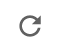 acima

In [60]:
# atualizar pip
!pip install -U pip setuptools

# instalar OpenAI gym do branch master ===> IMPORTANTE!
!pip install -e git+https://github.com/openai/gym.git@master#egg=gym

# Bokeh vizualization (maiores detalhes em github.com/bokeh/jupyter_bokeh)
!pip install bokeh jupyter_bokeh

Obtaining gym from git+https://github.com/openai/gym.git@master#egg=gym
  Updating /home/gui/learning/curso-verao-rl-ime-2021/src/gym clone (to revision master)
  Running command git fetch -q --tags
  Running command git reset --hard -q 8a721ace460cbaf8c3e6c03c12d06c616fd6e1e8
  Attempting uninstall: gym
    Found existing installation: gym 0.18.0
    Uninstalling gym-0.18.0:
      Successfully uninstalled gym-0.18.0
  Running setup.py develop for gym


### Imports

> **Atenção:** não se esqueça de executar todos os `imports` necessários antes prosseguir com o tutorial. 

In [62]:
import abc
import random

import gym

from utils.viz.viz_data_collection import plot_action_distribution, plot_episode_total_rewards

## 1. Ambientes no OpenAI Gym

Um ambiente no OpenAI Gym encapsula um simulador com o qual um agente pode interagir. Nesse simulador, a cada instante $t$ o agente deve escolhar uma ação $\mathbf{a}_t \in \mathcal{A}$ a ser executada. Ao receber essa ação, o ambiente tem seu estado $\mathbf{s}_t \in \mathcal{S}$ alterado para outro estado $\mathbf{s}_{t+1} \in \mathcal{S}$ e devolve para o agente uma observação (que pode ou não corresponder ao estado) e uma recompensa/punição $r_{t+1} \in \mathbb{R}$.

O pacote Gym conta com inúmeros [ambientes pré-programados](http://gym.openai.com/envs/) e prontos para serem usados para testar algoritmos de RL. Nessa parte prática, começaremos a explorar alguns ambientes mais simples a fim de nos familiarizarmos com os principais conceitos de modelagem da biblioteca Gym.

Para carregar um ambiente disponível no Gym basta chamar a função `gym.make` passando como argumento o identificador do ambiente:

In [64]:
env = gym.make("MountainCar-v0")

> **Atenção**: antes de usar um ambiente do Gym com o qual você não está familiarizado pode ser útil ler a sua documentação online.
> Para o `MountainCar-v0` acesse o link [http://gym.openai.com/envs/MountainCar-v0/](http://gym.openai.com/envs/MountainCar-v0/).

Informações adicionais sobre o ambiente/simulador podem ser obtidas accessando o atributo `env.spec`. Embora não seja obrigatório, muitos ambientes do OpenAI Gym definem  metadados importantes relacionados à tarefa de RL. Em particular, `env.spec.max_episode_steps` define o número máximo de passos de decisão que um agente pode tomar em um episódio (i.e., o tamanho máximo de uma trajetória) e `env.spec.reward_threshold` define o valor mínimo de retorno (i.e., recompensa total) de um episódio para o qual a tarefa é considerada resolvida.

In [66]:
print(f"MAX_EPISODE_STEPS = {env.spec.max_episode_steps}")
print(f"REWARD THRESHOLD = {env.spec.reward_threshold}")

MAX_EPISODE_STEPS = 200
REWARD THRESHOLD = -110.0


### 1.1. Espaço de estados e ações

Todo agente de RL deve conhecer quais ações pode tomar no ambiente e também quais as características das variáveis de observações que aquele ambiente lhe disponibiliza. Para acessar o espaço de estados e ações, um ambiente do gym disponibiliza os atributos `env.observation_space` e `env.action_space`, respectivamente.

Note que essas informações serão importantes futuramente na definição das entradas e saídas das redes neurais artificiais que utilizaremos para representar a política $\pi_\theta$ do agente e também na criação de outros modelos.   

Todo `observation_space` tem associado seu tipo numérico (e.g., int, float,...) e as dimensões de uma observação. Além disso, é possível saber se o valor das variáveis observação são limitadas ou não, e se forem limitadas qual o valor mínimo e máximo.

In [68]:
obs_space = env.observation_space

print(obs_space.dtype)
print(obs_space.shape)
print(obs_space.bounded_above, obs_space.high)
print(obs_space.bounded_below, obs_space.low)

float32
(2,)
[ True  True] [0.6  0.07]
[ True  True] [-1.2  -0.07]


Para o `MountainCar-v0` note que uma observação correponde a um vetor de números reais de tamanho 2 (i.e., um par de valores em ponto flutuante). Note que a primeira componente do vetor é limitada entre -1.2 e 0.6, e a segunda componente entre -0.07 e 0.07. 

Analogamente, todo `action_space` tem associado seu tipo numérico e as dimensões de uma ação:

In [70]:
action_space = env.action_space

print(action_space.dtype)
print(action_space.shape)
print(action_space.n)

int64
()
3


Note que para o `MountainCar-v0` o agente deverá escolher ações discretas (i.e., representadas por números inteiros). Observe também que o `shape==()` indica que uma ação é dada por um único escalar (e não um vetor como no caso do `observation_space`. Para acessar o número de possíveis valores da ação basta acessar o atributo `action_space.n`.

> **Atenção**: em algumas situações pode ser interessante ter acesso à amostras de observações e ações. Você pode usar os métodos `env.observation_space.sample()` e `env.action_space.sample()` para gerar aleatoriamente observações e ações direto do ambiente `env`. 

In [72]:
obs_samples = [env.observation_space.sample() for _ in range(3)]
print(obs_samples)

[array([-0.64009887, -0.01673872], dtype=float32), array([-0.33235228, -0.05541084], dtype=float32), array([-1.1966783 ,  0.00598221], dtype=float32)]


In [74]:
action_samples = [env.action_space.sample() for _ in range(5)]
print(action_samples)

[0, 2, 1, 0, 0]


### 1.2 Interface do Gym: métodos reset, step, render e close

Um objeto `env` do Gym fornece 4 métodos principais para interagir com o simulador: 
1. `reset` permite re-inicialiar o simulador para um de seus estados iniciais;
2. `step` se encarrega de executar uma ação no ambiente;
3. `render` visualiza graficamente o estado do agente; e
4. `close` libera recursos utilizados na simulação (por exemplo fecha a janela de visualização).

In [76]:
for i in range(5):
    obs = env.reset()
    print(f"obs {i} = {obs}")

obs 0 = [-0.48099318  0.        ]
obs 1 = [-0.43577233  0.        ]
obs 2 = [-0.41413213  0.        ]
obs 3 = [-0.47648057  0.        ]
obs 4 = [-0.59053116  0.        ]


Note que a observação do estado inicial muda conforme o método `.reset()` é chamado. Isso se deve ao fato de que o estado inicial é definido como uma variável aleatória regida por uma distribuição inicial.

In [78]:
obs = env.reset()

for i in range(5):
    action = env.action_space.sample()
    obs, reward, done, info = env.step(action)
    print(f"transition {i} = ({action}, {obs}, {reward})")

transition 0 = (1, [-5.42184998e-01  1.40375620e-04], -1.0)
transition 1 = (1, [-5.41905298e-01  2.79700071e-04], -1.0)
transition 2 = (1, [-5.41488368e-01  4.16929983e-04], -1.0)
transition 3 = (1, [-0.54093733  0.00055104], -1.0)
transition 4 = (1, [-0.54025631  0.00068102], -1.0)


> **Atenção**: Você pode se familiarizar com os argumentos e retorno de ambos os métodos através de seus *docstrings* acessados via `?`.

In [80]:
env.reset?

Signature: env.reset(**kwargs)
Docstring:
Resets the environment to an initial state and returns an initial
observation.

Note that this function should not reset the environment's random
number generator(s); random variables in the environment's state should
be sampled independently between multiple calls to `reset()`. In other
words, each call of `reset()` should yield an environment suitable for
a new episode, independent of previous episodes.

Returns:
    observation (object): the initial observation.
File:      ~/learning/curso-verao-rl-ime-2021/src/gym/gym/wrappers/time_limit.py
Type:      method


In [82]:
env.step?

Signature: env.step(action)
Docstring:
Run one timestep of the environment's dynamics. When end of
episode is reached, you are responsible for calling `reset()`
to reset this environment's state.

Accepts an action and returns a tuple (observation, reward, done, info).

Args:
    action (object): an action provided by the agent

Returns:
    observation (object): agent's observation of the current environment
    reward (float) : amount of reward returned after previous action
    done (bool): whether the episode has ended, in which case further step() calls will return undefined results
    info (dict): contains auxiliary diagnostic information (helpful for debugging, and sometimes learning)
File:      ~/learning/curso-verao-rl-ime-2021/src/gym/gym/wrappers/time_limit.py
Type:      method


## 2. Agentes 

A fim de permitir a implementação do **ciclo de interação Agente-Ambiente**, um agente de RL deve ser capaz de escolher uma ação para cada observação recebida do ambiente e aprender (i.e., melhorar sua performance) a partir de suas experiências.

Nesse contexto, na classe abstrata `Agent` definimos a interface geral de um agente de RL. 

> **Atenção**: Familiarize-se com essa classe; todos os agentes definidos nessa aula e nas próximas deverão especializar (i.e., derivar ou sub-classear) essa interface geral.

In [84]:
class Agent(abc.ABC):
    """
    Classe abstrata que define a interface básica de um agente RL.

    Args:
        obs_space:     especificação do espaço de observações do ambiente.
        action_space:  especificação do espaço de ações do ambiente.
        config (dict): (opcional) configurações de hiper-parâmetros.
    """

    def __init__(self, obs_space, action_space, config=None):
        self.obs_space = obs_space
        self.action_space = action_space
        self.config = config

    @abc.abstractmethod
    def step(self, obs):
        """
        Escolhe uma ação para ser tomada dada uma observação do ambiente.
        
        Args: 
            obs (np.ndarray): observação do ambiente.
        
        Return:
            action (np.ndarray): ação válida dentro do espaço de ações.
        """
        raise NotImplementedError

    @abc.abstractmethod
    def learn(self, batch):
        """
        Método de treinamento do agente. A partir de uma amostra de experiências,
        o agente aprende um novo comportamento.

        Args: 
            batch (Dict[str, np.ndarray]): Um batch de transições.

        Return:
            None
        """     
        raise NotImplementedError


### 2.1 Definindo um agente aleatório

Antes de finalmente definir o ciclo de interação agente-ambiente, vamos implementar um agente que escolhe ações aleatórias.

O agente `RandomPolicy` tem seu comportamento definido por uma política estocástica dada por uma distribuição uniforme sobre as ações válidas:

$$
\mathbf{a}_t \sim \pi(\cdot|\mathbf{s}) = \mathcal{Uniform}(\{ \mathbf{a} : \mathbf{a} \in \mathcal{A} \})~.
$$

Note que nesse ponto do curso, a implementação do agente aleatório é basicamente ilustrativa. No entanto, como veremos nas aulas seguintes, um agente que implementa uma política aleatória tem duas importantes funções:
1. servir de referência de performance final; e
2. guiar a inicialização de agentes de RL.

Em outras palavras, se um agente de RL após o treinamento não conseguir uma performance significativamente melhor do que aquela do agente aleatório, então muito provavelemente algo não está funcionando como deveria. Além disso, ao garantir que a inicialização de uma política induza um comportamente similar ao de um agente aleatório, não estaremos enviesando a exploração inicial do agente; o que poderia levar muito rapidamente para uma performance sub-ótima.

In [86]:
class RandomPolicy(Agent):
    """
    Agente aleatório. Escolhe aleatoriamente uma ação independentemente
    da observação recebida do ambiente.
    
    Args:
        action_space:  especificação do espaço de ações do ambiente.
    """
    
    def __init__(self, observation_space, action_space, config=None):
        super().__init__(observation_space, action_space, config)

    def step(self, obs):
        """Retorna uma ação aleatória."""
        del obs
        return self.action_space.sample()

    def learn(self, batch):
        """Um agente aletório não aprende; i.e., não melhora seu comportamento."""
        pass


Note que para uma mesma observação o agente `RandomPolicy` retorna diferentes ações a cada chamada:

In [88]:
agent = RandomPolicy(env.observation_space, env.action_space)

obs = env.reset()
print([agent.step(obs) for _ in range(20)])

[0, 0, 0, 0, 2, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 2]


In [90]:
plot_action_distribution(agent)

## 3. Ciclo de Interação Agente-Ambiente

Após entender a API do OpenAI Gym e se familiarizar com a interface geral de um agente de RL, estamos pronto para programar o ciclo de interação Agente-Ambiente.

Note que tanto o *treinamento* como a *avaliação de performance* de agentes de RL (baseados em simuladores) dependem da coleta de experiências a fim de estimar uma diferentes grandezas que são necessárias nos algoritmos de RL (e.g., retorno de episódios, gradientes de políticas, ...).

Esse é o objetivo principal do ciclo de interação com o ambiente: permitir ao agente explorar o ambiente e coletar dados para seu aprendizado.

> **Atenção**: Praticamente todos os pacotes de RL disponíveis implementam uma versão desse loop de interação. Dessa forma, independentemente se seu objetivo é desenvolver sua própria biblioteca de RL ou apenas re-utilizar código pré-existente, é importante entender os principais conceitos envolvidos!

Nessa seção testaremos a política aleatória em uma outra versão do ambiente MountainCar:

In [92]:
env = gym.make("MountainCarContinuous-v0")
agent = RandomPolicy(env.observation_space, env.action_space)

---

**<font color="red">EXERCÍCIO-PROGRAMA 1:</font>**

Nesse exercício você deverá utilizar os métodos da API do Gym a fim de permitir que um agente de RL simule um episódio. Complete a função `sample_episode` com seu código e preste atenção para retornar as variáveis definidas na documentação. Caso necessário revise a <a href="/lab#1.2-Interface-do-Gym:-métodos-reset(),-step()-e-render()" target="_self">Seção 1.2</a>.

>**Atenção**: Para visualizar o episódio não se esqueça de chamar `env.render()` durante a simulação da trajetória. Use a flag `render` em um *if-statement* do Python para dinamicamente habilitar a visualização. Uma vez que a parte gráfica consome muito tempo, é comum desabilitar a renderização do ambiente durante o treinamento e avaliação de um agente de RL. Além disso, chame `env.close()` ao final do ciclo para fechar a janela de simulação.

In [94]:
def sample_episode(agent, env, render=False):
    """
    Simula um episódio completo de interação do agente com o ambiente.
    
    Args:
        agent (RLAgent):       agente responsável por retornar ações.
        env (gym.Environment): simulador de ambiente do OpenAI Gym.
        render (bool):         (opcional) flag para habilitar a renderização do ambiente.
        
    Return:
        (total_reward, episode_length): retorno obtido pelo agente no episódio e
        número de passos de decisão realizados no episódio.
    """
    total_reward = 0.0
    episode_length = 0

    obs = env.reset()
    while episode_length < env.spec.max_episode_steps:
        if render: env.render()
        action = agent.step(obs)
        obs, reward, done, _ = env.step(action)
        total_reward   += reward
        episode_length += 1
        if done: break
    
    env.close()
    return total_reward, episode_length
    

Execute o código abaixo para testar a sua implementação.

In [96]:
total_reward, episode_length = sample_episode(agent, env, render=True)
print(f"return = {total_reward:.4f}, passos de decisão = {episode_length}\r", end="")

A menos que você tenha tido sorte na simulação, você deve ter observado que o carro nunca chega próximo à linha de chegada. :(

Não se preocupe vamos resolver isso nas próximas aulas!

---

Uma vez implementado a função `sample_episode` você pode amostrar diferentes trajetórias com a função `run` definida abaixo:

In [98]:
def run(agent, env, num_episodes):
    episode_returns, episode_lengths = [], []

    for episode in range(num_episodes):
        total_reward, episode_length = sample_episode(agent, env)
    
        episode_returns.append(total_reward)
        episode_lengths.append(episode_length)

        if episode % 10 == 0:
            print(f"episode = {episode}, return = {total_reward:.4f}, length = {episode_length}\r", end="")

    return episode_returns, episode_lengths
    

Execute o código abaixo para simular `NUM_EPISODES` trajetórias:

In [100]:
NUM_EPISODES = 200

episode_returns, episode_lengths = run(agent, env, NUM_EPISODES)

plot_episode_total_rewards(episode_returns)

> **Atenção**: se você obteve um pico de retorno com um valor positivo (i.e., *outlier*), execute novamente a simulação. Caso contrário, você deve ter obtido um retorno médio (vide linha vermelha) entre -34 e -33 para `NUM_EPISODES==200`.

---

**<font color="red">QUESTÕES:</font>**

1. Qual a diferença entre o ambiente `MountainCar-v0` utilizado como exemplo na <a href="/lab#1.-Ambientes-no-OpenAI-Gym" target="_self">Seção 1</a> e o ambiente `MountainCarContinuous-v0` que você acabou de simular?
2. Como você interpreta os gráficos acima `Episode Return` e `Episode Return (Histogram)` ? Como você explicaria essas variações ruidosas da recompensa total?
3. Se você executar a simulação várias vezes, obterá resultados ligeiramente diferentes? Ao que se deve essa incerteza nos resultados?
4. Você diria que o agente aleatório obteve uma boa performance? *Dica*: relacione os resultados obtidos com a especificação do ambiente `MountainCarContinuous-v0` (e.g., `env.spec`).
5. Note que durante a simulação o `Episode Length` se manteve constante ao longo dos episódios. O que isso significa do ponto de vista da tarefa de RL?

**<font color="red">RESPOSTAS:</font>**

1. No ambiente `MountainCar-v0`, o conjunto de ações é discreto, sendo um `int` entre `0` e `2`. Já no ambiente `MountainCarContinuous-v0`, o conjunto de ações é contínuo, sendo um `float32` entre `-1.` e `1.`.
2. O gráfico `Episode Return` mostra a recompensa total do $n$-ésimo episódio em função de $n$, enquanto o gráfico `Episode Return (Histogram)` mostra a frequência de um dado valor para a recompensa total. Os gráficos são ruidosos devido à aleatoriedade em cada episódio.
3. Sim, já que tanto o ambiente quando a política são estocásticos.
4. Não, pois a recompensa total média (cerca de -33) está bem abaixo da recompensa total desejada (90, já que este é o valor de `env.spec.reward_threshold`).
5. Isso indica que os episódios só acabam quando o número de _timesteps_ máximo (999, já que este é o valor de `env.spec.max_episode_steps`), e não quando o nosso agente atinge algum estado terminal, como chegar na bandeirinha.